In [4]:
import pandas as pd

train_df = pd.read_csv('./data/toxic_train.csv')
test_df = pd.read_csv('./data/toxic_test.csv')

In [5]:
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df

,comment_text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \r\n\r\nThat...,0
159568,"Spitzer \r\n\r\nUmm, theres no actual article ...",0
159569,And it looks like it was actually you who put ...,0


In [6]:
test_df = test_df.drop(columns=['Unnamed: 0'])
test_df

,comment_text,toxic
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \r\n\r\n It says it right there that it IS a...",0
4,""" \r\n\r\n == Before adding a new product to t...",0
...,...,...
63973,":Jerome, I see you never got around to this…! ...",0
63974,==Lucky bastard== \r\n http://wikimediafoundat...,0
63975,==shame on you all!!!== \r\n\r\n You want to s...,0
63976,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1


In [29]:
print(test_df['toxic'].value_counts())
print(train_df['toxic'].value_counts())

0    57888
1     6090
Name: toxic, dtype: int64
0    144277
1     15294
Name: toxic, dtype: int64


## Preprocessing

In [7]:
# selecting text data

train_df = train_df.sample(frac=1) #shuffling the training dataset
train = train_df['comment_text']
train = train.to_list()
train[:10]

['"\r\n\r\n Certainly.  On http://www.david-strathairn.com/media/film3.html there are several WMV files taken from HBO specials.  Those belong to and are copyright from HBO, and I see no ""used by permission"" there.  I see a note that says ""No copyright infringements intended."", but that doesn\'t say that it\'s NOT a copyright infringement - just becaus ethey say they didn\'t mean to doesn\'t mean it didn\'t happen. On the same page there are also copies of featurettes from commercially available DVDs.  These, too, will be copyrighted. One http://www.david-strathairn.com/media/tv3.html we have whole scenes taken from the HBO show ""The Sopranos"" - those are copyright HBO, too and again, I don\'t see a ""used with permission"" anywhere. On http://www.david-strathairn.com/media/radio.html there are all sorts of excerpts from radio shows, which are owned by the respective stations.  I see no permission given there either.  There is not doubt that all of these clips are copyrighted by 

### Creating a transformer for preprocessing text data

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize

import re

# transformer class
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords, stemmer):
        super().__init__()
        self.stopwords = stopwords
        self.stemmer = stemmer
        self.hapaxes = []
        self.named_entities = []
    
    # by default a transformer's fit method just returns self
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for i, sample in enumerate(X):
            X[i] = self.__normalize(sample)
            X[i] = self.__eliminate_stopwords(X[i])
            X[i] = self.__get_hapaxes(X[i])
            X[i] = self.__stem(X[i])
            self.__named_entity_extraction(X[i])
        
        return X

    def __normalize(self, text):
        return ' '.join(re.findall('[a-zA-Z]+', text.lower().replace(r'\r', ' ').replace(r'\n', ' ')))
    
    def __eliminate_stopwords(self, text):
        if self.stopwords is not None:
            return ''.join([word for word in text if word not in self.stopwords])
    
    def __get_hapaxes(self, text, eliminate=True):
        fd = FreqDist(word_tokenize(text))
        self.hapaxes.append(fd.hapaxes())
                       
        if eliminate:
            text = ''.join([word for word in text if word not in self.hapaxes])
        
        return text
    
    def __stem(self, text):
        return ' '.join([self.stemmer.stem(word) for word in word_tokenize(text)])
    
    def __named_entity_extraction(self, text):
        for sent in sent_tokenize(text):
            for chunk in nltk.ne_chunk(nltk.pos_tag(word_tokenize(sent))):
                if hasattr(chunk, 'label'):
                    self.named_entities.append(chunk)

### Using the transformer to preprocess the training text

In [9]:
from nltk.stem import PorterStemmer

transformer = TextTransformer(stopwords=['and', 'for', 'in', 'about', 'for', 'as', 'the'], stemmer=PorterStemmer())

In [10]:
train = transformer.transform(train[:1024])
train[:10]

['certainli on http www david strathairn com media film html there are sever wmv file taken from hbo special those belong to and are copyright from hbo and i see no use by permiss there i see a note that say no copyright infring intend but that doesn t say that it s not a copyright infring just becau ethey say they didn t mean to doesn t mean it didn t happen on the same page there are also copi of featurett from commerci avail dvd these too will be copyright one http www david strathairn com media tv html we have whole scene taken from the hbo show the soprano those are copyright hbo too and again i don t see a use with permiss anywher on http www david strathairn com media radio html there are all sort of excerpt from radio show which are own by the respect station i see no permiss given there either there is not doubt that all of these clip are copyright by the origin owner there is no evid that they are post with the owner s permiss therefor thi it is a reason conclus that thi is a

## Choosing the model

The plan is to test the accuracy of different models on the same dataset.

In [11]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

### The training dataset

In [12]:
X = pd.DataFrame(train, columns=['text']).dropna()['text'].values
y = train_df[:1024]['toxic'].dropna().values
X, y

(array(['certainli on http www david strathairn com media film html there are sever wmv file taken from hbo special those belong to and are copyright from hbo and i see no use by permiss there i see a note that say no copyright infring intend but that doesn t say that it s not a copyright infring just becau ethey say they didn t mean to doesn t mean it didn t happen on the same page there are also copi of featurett from commerci avail dvd these too will be copyright one http www david strathairn com media tv html we have whole scene taken from the hbo show the soprano those are copyright hbo too and again i don t see a use with permiss anywher on http www david strathairn com media radio html there are all sort of excerpt from radio show which are own by the respect station i see no permiss given there either there is not doubt that all of these clip are copyright by the origin owner there is no evid that they are post with the owner s permiss therefor thi it is a reason conclus that t

In [13]:
X.shape, y.shape

((1024,), (1024,))

### The testing dataset

In [14]:
X_test = test_df[:1024]['comment_text'].values
y_test = test_df[:1024]['toxic'].values
X_test, y_test

(array(['Thank you for understanding. I think very highly of you and would not revert without discussion.',
        ':Dear god this site is horrible.',
        '"::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding ""Religion"" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent ""Influences"" issue?  You\'re just flailing, making up crap on the fly. \r\n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    \r\n\r\n "',
        ...,
        '", 26 July 2010 (UTC) \r\n ::Can they be pink with blue spots?  Joking aside I don\'t think we can and it should probably stop.  Off2rio has taken this position on right wing articles for some time, generally against consensus.  Ditto on some of the British Isles disputes.  My original point (which I have probably repeated for too long) is that we have t

### Logistic Regression

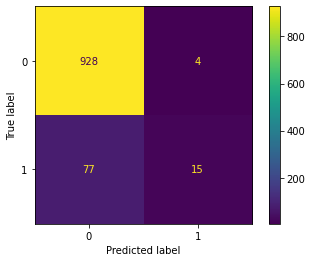

In [15]:
from sklearn.linear_model import LogisticRegression

lr_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    LogisticRegression()
)

lr_pipe.fit(X, y)
plot_confusion_matrix(lr_pipe, X_test, y_test)

### NB models

Complement Naive Bayes
Bernoulli Naive Bayes
Multinomial Naive Bayes


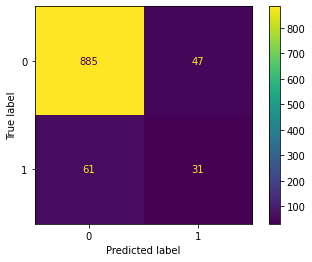

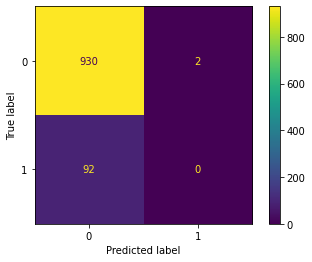

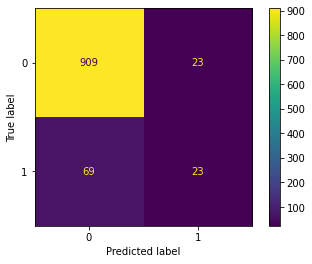

In [16]:
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB

cnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    ComplementNB()
)

bnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    BernoulliNB()
)

mnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    MultinomialNB()
)

# fitting the models
cnb_pipe.fit(X, y)
print('Complement Naive Bayes')
plot_confusion_matrix(cnb_pipe, X_test, y_test)

bnb_pipe.fit(X, y)
print('Bernoulli Naive Bayes')
plot_confusion_matrix(bnb_pipe, X_test, y_test)

mnb_pipe.fit(X, y)
print('Multinomial Naive Bayes')
plot_confusion_matrix(mnb_pipe, X_test, y_test)

### Decision Tree

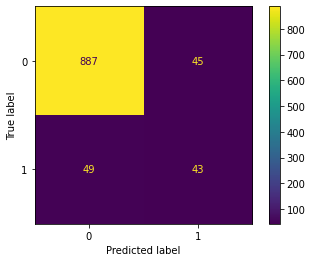

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    DecisionTreeClassifier()
)

dt_pipe.fit(X, y)
plot_confusion_matrix(dt_pipe, X_test, y_test)

### K-nearest neighbors

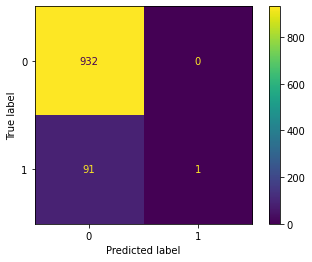

In [18]:
from sklearn.neighbors import KNeighborsClassifier

kn_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    KNeighborsClassifier()
)

kn_pipe.fit(X, y)
plot_confusion_matrix(kn_pipe, X_test, y_test)

### Perceptron

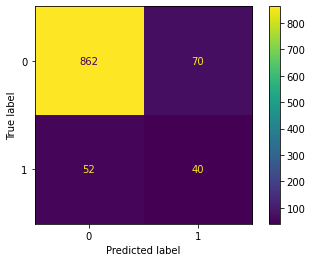

In [19]:
from sklearn.linear_model import Perceptron

p_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    Perceptron()
)

p_pipe.fit(X, y)
plot_confusion_matrix(p_pipe, X_test, y_test)

### Support Vector Machine

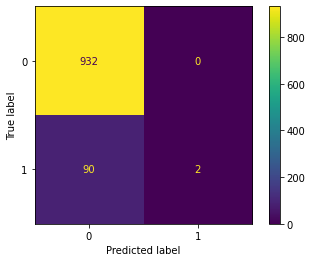

In [20]:
from sklearn.svm import SVC

svm_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    SVC()
)

svm_pipe.fit(X, y)
plot_confusion_matrix(svm_pipe, X_test, y_test)

## Comparing accuracy scores

In [21]:
scores = {
    'Logistic Regression': [accuracy_score(y_test, lr_pipe.predict(X_test))],
    'Complement NB': [accuracy_score(y_test, cnb_pipe.predict(X_test))],
    'Bernoulli NB': [accuracy_score(y_test, bnb_pipe.predict(X_test))],
    'Multinomail Regression': [accuracy_score(y_test, mnb_pipe.predict(X_test))],
    'K-nearest neighbors': [accuracy_score(y_test, kn_pipe.predict(X_test))],
    'Perceptron': [accuracy_score(y_test, p_pipe.predict(X_test))],
    'SVM': [accuracy_score(y_test, svm_pipe.predict(X_test))]
}

scores_df = pd.DataFrame.from_dict(scores)
scores_df

,Logistic Regression,Complement NB,Bernoulli NB,Multinomail Regression,K-nearest neighbors,Perceptron,SVM
0,0.920898,0.894531,0.908203,0.910156,0.911133,0.880859,0.912109


In [22]:
# the best accuracy
model_name = scores_df.idxmax(axis=1)[0]
f'{model_name} : {scores_df[model_name][0]}'

'Logistic Regression : 0.9208984375'

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_pipe.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       932
           1       0.79      0.16      0.27        92

    accuracy                           0.92      1024
   macro avg       0.86      0.58      0.61      1024
weighted avg       0.91      0.92      0.90      1024



In [32]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lr_pipe.predict(X_test)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lr_pipe.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lr_pipe.predict(X_test))))

Mean Absolute Error: 0.0791015625
Mean Squared Error: 0.0791015625
Root Mean Squared Error: 0.28125
